# Analyse de Sentiments sur Twitter avec SparkSQL

In [1]:
%pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 1.1 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, split, explode, lower, udf
from pyspark.sql.types import StringType, IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd

spark = SparkSession.builder \
    .appName("Twitter Sentiment Analysis") \
    .getOrCreate()

## Chargement du jeu de données

In [5]:

file_path = "/app/data/sentiment140_sample.csv"  
df = spark.read.csv(file_path, header=False, inferSchema=True)


df = df.toDF("target", "ids", "date", "flag", "user", "text")

print("Affichage des 5 premières lignes du DataFrame :")
df.show(5)

# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("tweets")

Affichage des 5 premières lignes du DataFrame :
+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



## Analyse des sentiments : Comptage 

In [6]:
sentiment_counts = spark.sql("""
SELECT target,
       COUNT(*) AS count
FROM tweets
GROUP BY target
ORDER BY count DESC
""")

print("\nComptage des sentiments :")
sentiment_counts.show()


Comptage des sentiments :
+------+------+
|target| count|
+------+------+
|     0|800000|
|     4|800000|
+------+------+



## Top 10 utilisateurs avec le plus de tweets

In [8]:
top_users = spark.sql("""
SELECT user,
       COUNT(*) AS count
FROM tweets
GROUP BY user
ORDER BY count DESC
LIMIT 10
""")
print("\nTop 10 utilisateurs avec le plus de tweets :")
top_users.show()


Top 10 utilisateurs avec le plus de tweets :
+---------------+-----+
|           user|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
+---------------+-----+



## Visualisation du Top 10 des utilisateurs

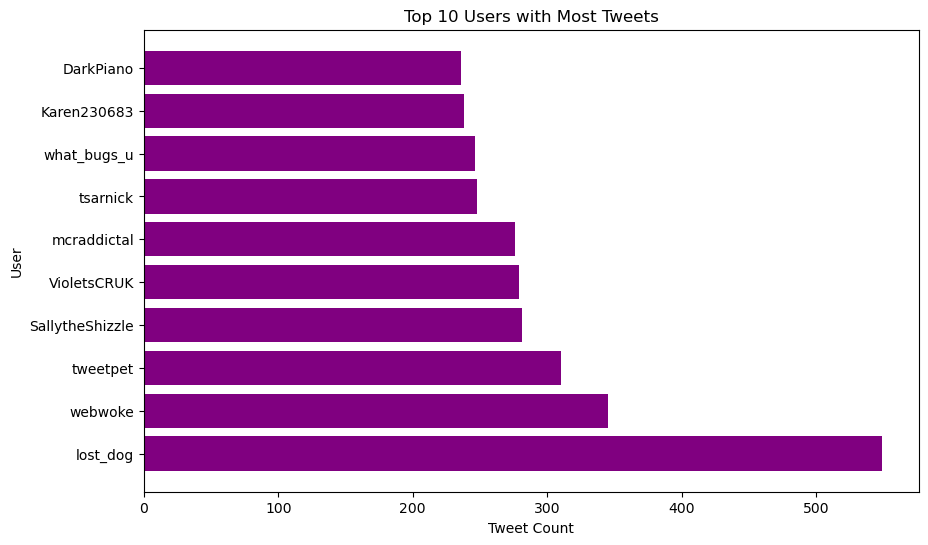

In [9]:
top_users_pd = top_users.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_users_pd['user'], top_users_pd['count'], color='purple')
plt.title('Top 10 Users with Most Tweets')
plt.ylabel('User')
plt.xlabel('Tweet Count')
plt.show()

## Top 10 sentiments par utilisateur

In [10]:
user_sentiment = spark.sql("""
SELECT user,
       target,
       COUNT(*) AS count
FROM tweets
GROUP BY user, target
ORDER BY count DESC
LIMIT 10
""")
print("\nTop 10 sentiments par utilisateur :")
user_sentiment.show()


Top 10 sentiments par utilisateur :
+-----------+------+-----+
|       user|target|count|
+-----------+------+-----+
|   lost_dog|     0|  549|
|   tweetpet|     0|  310|
|    webwoke|     0|  264|
|what_bugs_u|     4|  246|
|  DarkPiano|     4|  231|
|VioletsCRUK|     4|  218|
|   tsarnick|     4|  212|
|     keza34|     4|  211|
|mcraddictal|     0|  210|
|     wowlew|     0|  210|
+-----------+------+-----+



## Visualisation des Top 10 sentiments par utilisateur

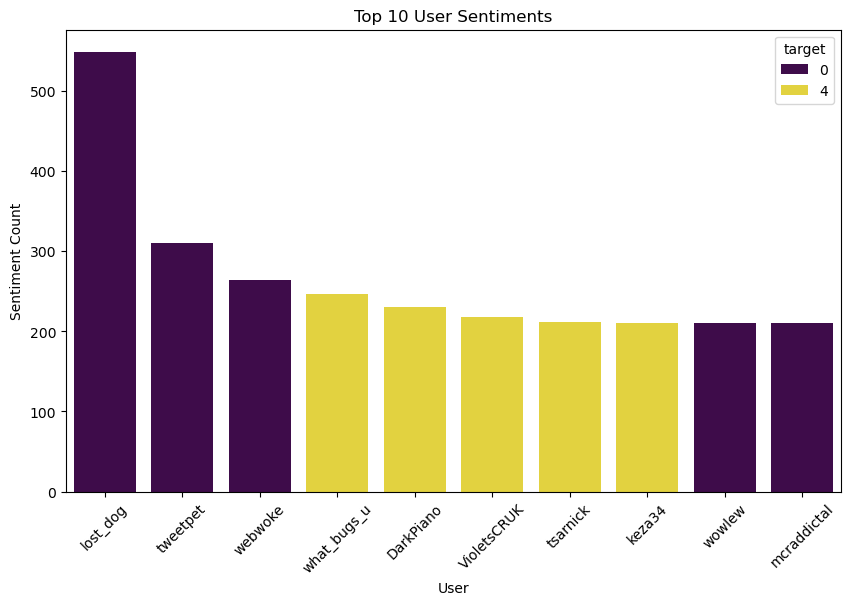

In [11]:
user_sentiment_pd = user_sentiment.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='user', y='count', hue='target', data=user_sentiment_pd, palette='viridis')
plt.title('Top 10 User Sentiments')
plt.xlabel('User')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45)
plt.show()

## Top 10 utilisateurs positifs

In [12]:
df.createOrReplaceTempView("sentiment_analysis")

top_positive_users = spark.sql("""
    SELECT user, COUNT(*) AS positive_count
    FROM sentiment_analysis
    WHERE target = 4  -- Positive sentiment
    GROUP BY user
    ORDER BY positive_count DESC
    LIMIT 10
""")

print("\nTop 10 utilisateurs positifs :")
top_positive_users.show()


Top 10 utilisateurs positifs :
+--------------+--------------+
|          user|positive_count|
+--------------+--------------+
|   what_bugs_u|           246|
|     DarkPiano|           231|
|   VioletsCRUK|           218|
|      tsarnick|           212|
|        keza34|           211|
|     shanajaca|           204|
|  TraceyHewins|           193|
|ramdomthoughts|           190|
|  thisgoeshere|           178|
|KevinEdwardsJr|           171|
+--------------+--------------+



## Visualisation des Top 10 utilisateurs positifs

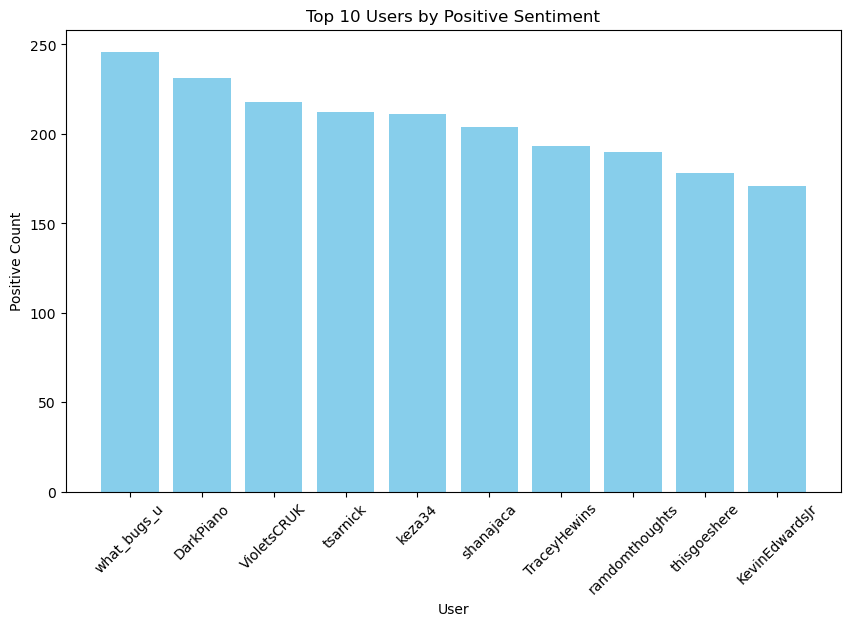

In [13]:
top_positive_users_pd = top_positive_users.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_positive_users_pd['user'], top_positive_users_pd['positive_count'], color='skyblue')
plt.title('Top 10 Users by Positive Sentiment')
plt.xlabel('User')
plt.ylabel('Positive Count')
plt.xticks(rotation=45)
plt.show()

## Top 10 utilisateurs négatifs

In [14]:
top_negative_users = spark.sql("""
    SELECT user, COUNT(*) AS negative_count
    FROM sentiment_analysis
    WHERE target = 0  -- Negative sentiment
    GROUP BY user
    ORDER BY negative_count DESC
    LIMIT 10
""")

print("\nTop 10 utilisateurs négatifs :")
top_negative_users.show()


Top 10 utilisateurs négatifs :
+---------------+--------------+
|           user|negative_count|
+---------------+--------------+
|       lost_dog|           549|
|       tweetpet|           310|
|        webwoke|           264|
|    mcraddictal|           210|
|         wowlew|           210|
|SallytheShizzle|           183|
|    _magic8ball|           136|
|        Dogbook|           133|
|mrs_mcsupergirl|           123|
|     nuttychris|           121|
+---------------+--------------+



## Visualisation des Top 10 utilisateurs négatifs

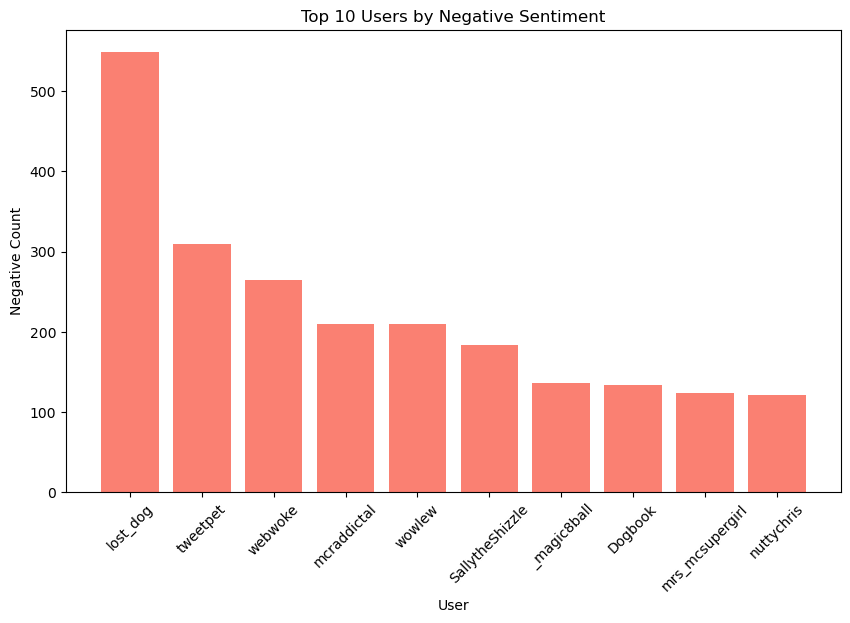

In [15]:
top_negative_users_pd = top_negative_users.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_negative_users_pd['user'], top_negative_users_pd['negative_count'], color='salmon')
plt.title('Top 10 Users by Negative Sentiment')
plt.xlabel('User')
plt.ylabel('Negative Count')
plt.xticks(rotation=45)
plt.show()

## Tendances de sentiment au fil du temps

In [16]:
df.createOrReplaceTempView("time_analysis")

sentiment_trends = spark.sql("""
    SELECT date, 
           target, 
           COUNT(*) AS tweet_count
    FROM time_analysis
    GROUP BY date, target
    ORDER BY date
""")

print("\nTendances de sentiment au fil du temps :")
sentiment_trends.show()


Tendances de sentiment au fil du temps :
+--------------------+------+-----------+
|                date|target|tweet_count|
+--------------------+------+-----------+
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:30:...|     0|          2|
|Fri Apr 17 20:30:...|     0|          2|
|Fri Apr 17 20:30:...|     0|          3|
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:30:...|     0|          2|
|Fri Apr 17 20:30:...|     0|          1|
|Fri Apr 17 20:31:...|     0|          1|
|Fri Apr 17 20:31:...|     0|          2|
|Fri Apr 17 20:31:...|     0|          1|
|Fri Apr 17 20:31:...|     0|          1|
|Fri Apr 17 20:31:...|     0|          1|
|Fri Apr 17 20:31:...|     0|          2|
|Fri Apr 17 20:31:...|     0|          2|
|Fri Apr 17 20:31:...|     0|     

## Top 10 mots dans les tweets positifs

In [ ]:
@udf(StringType())
def extract_sentiment(text):
  if "sad" in text or "bummer" in text or "hate" in text:
    return "negative"
  elif "love" in text or "happy" in text or "great" in text:
    return "positive"
  else:
    return "neutral"

# Apply the UDF to create a new column for sentiment
df = df.withColumn("sentiment", extract_sentiment(col("text")))

# Tokenize text and remove stop words
word_frequency_df = df.selectExpr("explode(split(lower(text), ' ')) AS word", "sentiment") \
                      .filter("word != ''") \
                      .filter("word NOT IN ('the', 'and', 'to', 'of', 'in', 'a', 'for', 'on', 'with', 'is', 'at', 'it', 'that', 'as', 'an', 'by', 'this', 'or', 'from', 'are', 'you', 'your', 'be', 'have', 'has', 'was', 'were', 'if', 'but', 'not', 'about', 'so', 'out', 'up', 'can', 'will', 'all', 'no', 'there', 'they', 'their', 'when', 'one', 'who', 'how', 'what', 'where', 'why', 'which', 'then', 'than', 'more', 'just', 'would', 'should', 'could', 'did', 'does', 'been', 'being')")

# Analyze word frequency by sentiment
positive_word_freq = word_frequency_df.filter("sentiment = 'positive'") \
                                      .groupBy("word") \
                                      .count() \
                                      .orderBy("count", ascending=False) \
                                      .limit(10)

print("\nTop 10 mots dans les tweets positifs :")
positive_word_freq.show()


Top 10 mots dans les tweets positifs :
+------+-----+
|  word|count|
+------+-----+
|     i|   35|
|  love|   28|
| great|   11|
|   i'm|    7|
|lovely|    6|
|    me|    6|
| happy|    6|
|     -|    5|
|    my|    5|
|  like|    5|
+------+-----+



## Visualisation des Top 10 mots dans les tweets positifs

/tmp/ipykernel_273/1018917041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=positive_word_freq_pd, x='word', y='count', palette='Blues_d')


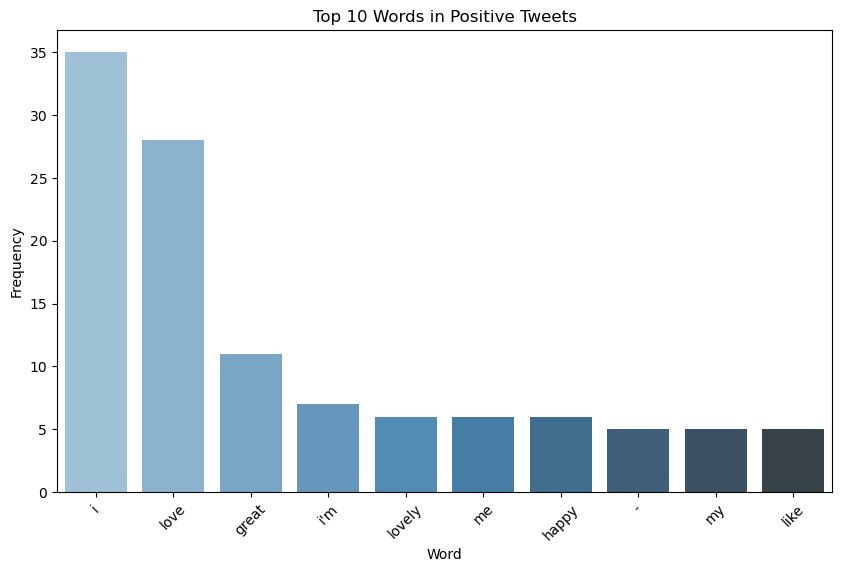

In [ ]:
positive_word_freq_pd = positive_word_freq.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=positive_word_freq_pd, x='word', y='count', palette='Blues_d')
plt.title('Top 10 Words in Positive Tweets')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Top 10 mots dans les tweets négatifs

In [ ]:
negative_word_freq = word_frequency_df.filter("sentiment = 'negative'") \
                                      .groupBy("word") \
                                      .count() \
                                      .orderBy("count", ascending=False) \
                                      .limit(10)

print("\nTop 10 mots dans les tweets négatifs :")
negative_word_freq.show()


Top 10 mots dans les tweets négatifs :
+-----+-----+
| word|count|
+-----+-----+
|    i|   27|
| hate|   13|
|  sad|   10|
|   my|   10|
|   me|    6|
| sad.|    5|
| like|    4|
|can't|    4|
| it's|    4|
|makes|    3|
+-----+-----+



## Visualisation des Top 10 mots dans les tweets négatifs

/tmp/ipykernel_273/1884816382.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=negative_word_freq_pd, x='word', y='count', palette='Reds_d')


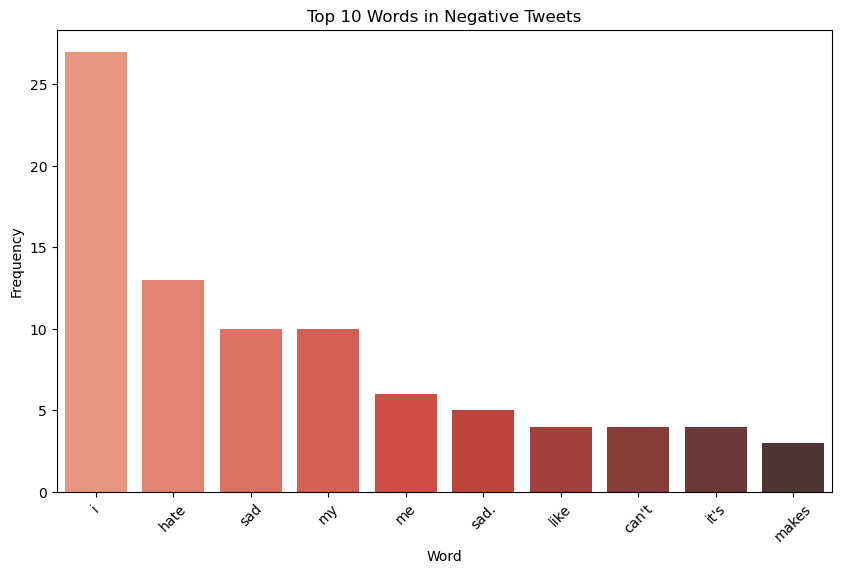

In [ ]:
negative_word_freq_pd = negative_word_freq.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=negative_word_freq_pd, x='word', y='count', palette='Reds_d')
plt.title('Top 10 Words in Negative Tweets')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Arrêt de la session Spark

In [ ]:
spark.stop()